<a href="https://colab.research.google.com/github/Nivetha96/NLP_Notebooks/blob/master/Text_Classification_using_TFIDF_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install h2o

     |████████████████████████████████| 164.6MB 63kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=d65e4c9754556a3d500ee017d618a17359b513631eb001ccf6e2886159cd6751
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [7]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzyqglwjm
  JVM stdout: /tmp/tmpzyqglwjm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzyqglwjm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_3n0796
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
df = pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')

In [11]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


In [12]:
df.shape

(57453, 18)

In [13]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [17]:
df.describe(include='all')

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,0.0,5.745300e+04
unique,354,6,32,44,160,55390,11,2197,60,2874,4,1,1,359,5,2,NaN,NaN
top,4/23/2020,Debt collection,General-purpose credit card or charge card,Attempts to collect debt not owed,None,I am a victim of identity theft and this debt ...,None,"CITIBANK, N.A.",CA,None,None,Consent provided,Web,5/21/2020,Closed with explanation,Yes,NaN,NaN
freq,293,21772,9968,10326,10009,318,30661,3226,7938,13708,45951,57453,57453,300,47819,55987,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.498561e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.091834e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.315180e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.405102e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.491446e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.588478e+06


In [14]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

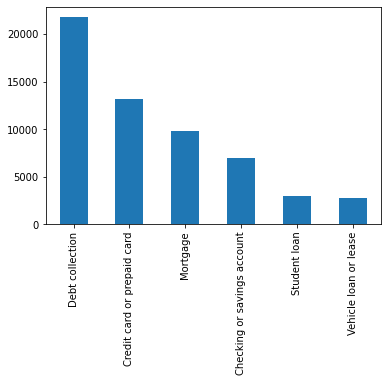

In [15]:
df['Product'].value_counts().plot(kind='bar')

In [16]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
FlexShopper, Inc                            1
Home Financial Corporation                  1
CrossCheck, Inc.                            1
WALLICK AND VOLK, INC                       1
Davis, Pickren, Seydel & Sneed, LLP         1
Name: Company, Length: 2197, dtype: int64

In [22]:
complaints_df = df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'Complaint'})

In [23]:
complaints_df.head()

,Complaint,Product,Company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."


In [24]:
complaints_df['Product'] = complaints_df['Product'].astype('category')

In [25]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
complaints_df['Product_Category'] = labelencoder.fit_transform(complaints_df['Product'])
complaints_df.head()

,Complaint,Product,Company,Product_Category
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings,2
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,0
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc.",2


In [26]:
X_train,X_test = train_test_split(complaints_df,test_size=0.8,random_state=11)

In [27]:
stemmer = nltk.stem.SnowballStemmer('english')

In [28]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+','',word.strip('Xx/'))))]
  tokens = map(str.lower,tokens)
  stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [30]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.Complaint) 

In [31]:
train_vectors.A

array([[0.        , 0.20657857, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05276621, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [32]:
vectorizer_tf.get_feature_names()

['0.00',
 '100.00',
 '1000.00',
 '1200.00',
 '1500.00',
 '200.00',
 '2000.00',
 '300.00',
 '500.00',
 'abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'access account',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'ar

In [33]:
test_vectors = vectorizer_tf.transform(X_test.Complaint)

In [34]:
X_train.shape

(11490, 4)

In [36]:
X_train.head()

,Complaint,Product,Company,Product_Category
46683,I contacted citi to change my credit card for ...,Credit card or prepaid card,"CITIBANK, N.A.",1
12603,"Calvary SPV I, LLC, original debt is XXXX. I w...",Debt collection,"CAVALRY INVESTMENTS, LLC",2
49439,I asked them to verify and validate accountXX/...,Debt collection,Ad Astra Recovery Services Inc,2
18720,I experienced an issue with my car smelling of...,Vehicle loan or lease,NISSAN MOTOR ACCEPTANCE CORPORATION,5
54200,I was just informed that a chase employee name...,Checking or savings account,JPMORGAN CHASE & CO.,0


In [38]:
train_df = pd.DataFrame(train_vectors.toarray(), columns = vectorizer_tf.get_feature_names())
train_df = pd.concat([train_df,X_train['Product_Category'].reset_index(drop=True)],axis=1)
train_df.head()

,0.00,100.00,1000.00,1200.00,1500.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,...,victim ident,violat,violat fair,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,yesterday,zero,Product_Category
0,0.0,0.206579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.256293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066956,0.0,0.0,0.0,0.000000,0.0,0.0,0.033255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152282,0.0,0.0,0.0,0.0,0.064987,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066168,0.0,0.098659,0.0,0.0,0.0,0.0,0.000000,0.0,0.124493,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.052766,0.0,0.0,2
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.187679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,2
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.085751,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,5
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.105349,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.162743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13174,0.000000,0.0,0.0,0


In [39]:
train_df.shape

(11490, 1001)

In [40]:
test_df = pd.DataFrame(test_vectors.toarray(), columns = vectorizer_tf.get_feature_names())
test_df = pd.concat([test_df,X_test['Product_Category'].reset_index(drop=True)],axis=1)
test_df.head()

,0.00,100.00,1000.00,1200.00,1500.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,...,victim ident,violat,violat fair,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,yesterday,zero,Product_Category
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,2
1,0.0,0.424773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.074667,0.0,0.0,4
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132782,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148507,0.0,0.0,0.0,0.0,0.000000,0.126061,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.120561,0.0,0.0,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16796,0.000000,0.0,0.0,0.0,0.0,0.0,0.13527,0.058028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,3
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.028029,0.0,0.0,0.0,0.0,0.0,0.00000,0.111369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024328,0.0,0.0,0.0,0.052717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025438,0.121260,0.0,0.0,0.0,0.0,0.032263,0.0,0.065486,0.0,0.000000,0.0,0.0,1


In [41]:
test_df.shape

(45963, 1001)

In [42]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
h2o_train_df.types

{'0.00': 'real',
 '100.00': 'real',
 '1000.00': 'real',
 '1200.00': 'real',
 '1500.00': 'real',
 '200.00': 'real',
 '2000.00': 'real',
 '300.00': 'real',
 '500.00': 'real',
 'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'access account': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': '

In [44]:
h2o_train_df['Product_Category'] = h2o_train_df['Product_Category'].asfactor()
h2o_test_df['Product_Category'] = h2o_test_df['Product_Category'].asfactor()

In [45]:
aml = H2OAutoML(max_models=10, seed=10, exclude_algos=['StackedEnsemble'],verbosity="info",nfolds=0, balance_classes=True,max_after_balance_size=0.3)

In [46]:
x = vectorizer_tf.get_feature_names()
y = 'Product_Category'

In [47]:
aml.train(x=x, y=y, training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
06:42:38.820: Project: AutoML_20201130_64238815
06:42:38.821: Cross-validation disabled by user: no fold column nor nfolds > 1.
06:42:38.827: Setting stopping tolerance adaptively based on the training frame: 0.00932910509720565
06:42:38.827: Build control seed: 10
06:42:38.827: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
06:42:40.630: training frame: Frame key: automl_training_py_1_sid_ad9d    cols: 1001    rows: 10339  chunks: 14    size: 8688245  checksum: -8367929200961730552
06:42:40.635: validation frame: Frame key: py_2_sid_ad9d    cols: 1001    rows: 45963  chunks: 53    size: 38268651  checksum: -3042196525458515791
06:42:40.818: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_ad9d    cols: 1001    rows: 1151  chunks: 14    size: 1896233  checksum: 8467831822641329848
06:42:40.818: blending frame: NULL
06:42:40.818: response 

In [48]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
GBM_3_AutoML_20201130_064238,0.16303,0.44959,0.361044,0.130353
XGBoost_1_AutoML_20201130_064238,0.16362,0.392162,0.333581,0.111276
GBM_4_AutoML_20201130_064238,0.173821,0.485716,0.360687,0.130095
XGBoost_2_AutoML_20201130_064238,0.175584,0.40897,0.343458,0.117963
XGBoost_3_AutoML_20201130_064238,0.179465,0.379676,0.336154,0.112999
GLM_1_AutoML_20201130_064238,0.184943,0.415434,0.358587,0.128585
GBM_2_AutoML_20201130_064238,0.196181,0.472351,0.376986,0.142119
GBM_1_AutoML_20201130_064238,0.197097,0.490502,0.382888,0.146603
GBM_5_AutoML_20201130_064238,0.213836,0.480737,0.378888,0.143556
DRF_1_AutoML_20201130_064238,0.307164,0.632981,0.463703,0.215021


In [49]:
pred = aml.leader.predict(h2o_test_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [50]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.13117368084259312
RMSE: 0.3621790728943255
LogLoss: 0.4568086873164138
Mean Per-Class Error: 0.17988256618696638

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4588.0,666.0,220.0,78.0,7.0,25.0,0.178367,"996 / 5,584"
1,579.0,8940.0,749.0,129.0,31.0,103.0,0.151078,"1,591 / 10,531"
2,215.0,1263.0,15143.0,311.0,236.0,262.0,0.131211,"2,287 / 17,430"
3,99.0,208.0,379.0,7037.0,72.0,110.0,0.109804,"868 / 7,905"
4,8.0,110.0,205.0,53.0,1913.0,42.0,0.179322,"418 / 2,331"
5,39.0,205.0,368.0,61.0,46.0,1463.0,0.329514,"719 / 2,182"
6,5528.0,11392.0,17064.0,7669.0,2305.0,2005.0,0.149664,"6,879 / 45,963"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.850336
1,2,0.944760
2,3,0.975132
3,4,0.988121
4,5,0.996171
5,6,1.000000


In [52]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [53]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20201130_064238


Model Summary: 


,,number_of_trees
0,,60.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.028555508414595584
RMSE: 0.16898375192483917
LogLoss: 0.1119868623922563
Mean Per-Class Error: 0.03395713363189506

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,1249.0,17.0,16.0,0.0,0.0,0.0,0.025741,"33 / 1,282"
1,9.0,2345.0,49.0,0.0,1.0,1.0,0.024948,"60 / 2,405"
2,7.0,25.0,3850.0,7.0,2.0,1.0,0.010791,"42 / 3,892"
3,2.0,8.0,15.0,1676.0,0.0,0.0,0.014697,"25 / 1,701"
4,0.0,14.0,14.0,0.0,527.0,2.0,0.053860,30 / 557
5,0.0,19.0,15.0,1.0,2.0,465.0,0.073705,37 / 502
6,1267.0,2428.0,3959.0,1684.0,532.0,469.0,0.021956,"227 / 10,339"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.978044
1,2,0.995067
2,3,0.998839
3,4,0.999613
4,5,1.000000
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.11307628037867211
RMSE: 0.33626816735854154
LogLoss: 0.3909361746646058
Mean Per-Class Error: 0.18014120453677376

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4643.0,597.0,246.0,76.0,8.0,14.0,0.168517,"941 / 5,584"
1,529.0,9037.0,827.0,61.0,20.0,57.0,0.141867,"1,494 / 10,531"
2,172.0,647.0,15998.0,270.0,147.0,196.0,0.082157,"1,432 / 17,430"
3,84.0,175.0,319.0,7181.0,63.0,83.0,0.091588,"724 / 7,905"
4,9.0,91.0,255.0,98.0,1831.0,47.0,0.214500,"500 / 2,331"
5,40.0,200.0,404.0,132.0,58.0,1348.0,0.382218,"834 / 2,182"
6,5477.0,10747.0,18049.0,7818.0,2127.0,1745.0,0.128908,"5,925 / 45,963"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.871092
1,2,0.955072
2,3,0.980093
3,4,0.991711
4,5,0.997172
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-11-30 06:42:41,0.287 sec,0.0,0.833333,1.791759,0.623561,0.833333,1.791759,0.620782
1,,2020-11-30 06:42:50,9.698 sec,5.0,0.465803,0.642526,0.121288,0.491738,0.708183,0.159541
2,,2020-11-30 06:42:56,15.585 sec,10.0,0.353871,0.405374,0.098269,0.403920,0.514976,0.147532
3,,2020-11-30 06:43:02,21.994 sec,15.0,0.303342,0.305208,0.079988,0.373121,0.449080,0.140156
4,,2020-11-30 06:43:08,27.774 sec,20.0,0.272278,0.249779,0.066544,0.358645,0.419971,0.135848
5,,2020-11-30 06:43:15,34.193 sec,25.0,0.251865,0.216190,0.056872,0.351197,0.406531,0.134108
6,,2020-11-30 06:43:21,40.129 sec,30.0,0.234961,0.191593,0.047877,0.346460,0.398828,0.132781
7,,2020-11-30 06:43:28,47.654 sec,35.0,0.219903,0.170983,0.041300,0.343200,0.394321,0.131388
8,,2020-11-30 06:43:35,54.859 sec,40.0,0.207481,0.155258,0.036464,0.341046,0.391940,0.131280
9,,2020-11-30 06:43:41,1 min 0.815 sec,45.0,0.195789,0.141563,0.030757,0.339618,0.391013,0.130213



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,card,3407.156738,1.000000,0.086240
1,mortgag,3107.726318,0.912117,0.078661
2,debt,2569.439697,0.754130,0.065036
3,collect,2457.831055,0.721373,0.062212
4,loan,2111.106689,0.619610,0.053435
5,bank,1685.687012,0.494749,0.042667
6,student,993.004211,0.291447,0.025134
7,payment,928.956238,0.272649,0.023513
8,vehicl,778.513794,0.228494,0.019705
9,deposit,734.885437,0.215689,0.018601



See the whole table with table.as_data_frame()


In [54]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 10,
  'min_child_weight': 5.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 10,
  'silent': True,
  'subsample': 0.6,
  'tree_method': 'exact'},
 10000)

In [55]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [56]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)

In [57]:
xgb_clf.fit(train_vectors,X_train['Product_Category'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [58]:
predictions = xgb_clf.predict(test_vectors)

In [59]:
cm = confusion_matrix(X_test['Product_Category'],predictions)
print(cm)

[[ 4527   575   379    75    13    15]
 [  480  8902  1055    51     8    35]
 [  195   686 15961   264   162   162]
 [  118   174   418  7093    43    59]
 [    6   103   272   108  1815    27]
 [   46   244   470   123    45  1254]]


In [60]:
print('classification report: \n',classification_report(X_test['Product_Category'],predictions))

classification report: 
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      5584
           1       0.83      0.85      0.84     10531
           2       0.86      0.92      0.89     17430
           3       0.92      0.90      0.91      7905
           4       0.87      0.78      0.82      2331
           5       0.81      0.57      0.67      2182

    accuracy                           0.86     45963
   macro avg       0.86      0.80      0.83     45963
weighted avg       0.86      0.86      0.86     45963



In [61]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(X_train['Product_Category']),X_train['Product_Category']))

In [62]:
class_weights

[1.3495419309372798,
 0.7193839218632607,
 0.44104099493321053,
 1.0110876451953537,
 3.0936995153473346,
 3.4566787003610107]

In [63]:
weights = np.ones(X_train.shape[0],dtype='float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [64]:
for i,val in enumerate(X_train['Product_Category']):
  weights[i] = class_weights[val]

In [65]:
weights

array([0.71938392, 0.44104099, 0.44104099, ..., 3.09369952, 0.44104099,
       0.44104099])

In [66]:
xgb_clf.fit(train_vectors,X_train['Product_Category'],sample_weight=weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [67]:
predictions = xgb_clf.predict(test_vectors)

In [68]:
cm = confusion_matrix(X_test['Product_Category'],predictions)
print(cm)

[[ 4875   395   141    70    31    72]
 [  822  8511   648    68    26   456]
 [  458   768 15004   289   353   558]
 [  142    90   216  6961   202   294]
 [   11    29   121    17  1993   160]
 [   56    87   218    46    79  1696]]


In [69]:
print('classification report: \n',classification_report(X_test['Product_Category'],predictions))

classification report: 
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      5584
           1       0.86      0.81      0.83     10531
           2       0.92      0.86      0.89     17430
           3       0.93      0.88      0.91      7905
           4       0.74      0.85      0.79      2331
           5       0.52      0.78      0.63      2182

    accuracy                           0.85     45963
   macro avg       0.79      0.84      0.81     45963
weighted avg       0.86      0.85      0.85     45963

